# Workflow


The overall workflow is as such:

<ol>
    <li>EDA and imputation process - check missing values, unique values etc and imputation. Query comes from SQL, only SG properties</li>
   <li>Feature selection process - recursively eliminate with VIF. See if any features need to be dropped</li>
   
   <li>Determine suitability for methods. Train an OLS model, check the residuals/fitted values of the beta matrix. Assumptions (Normality of residuals, autocorrelation of residuals, homoskedasticity of residuals). If 0 or 1 assumptions met, reject and use ensemble If 2 or more assumptions met, use OLS.</li>
    <li>Test models</li>
    <li> Convert notebook to proper directory structure </li>
</ol>


# Setup

In [70]:
!pip install patsy

In [2]:
import pandas as pd
import numpy as np
import math
import statistics
import os
from datetime import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from patsy import dmatrices

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad, het_white
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings('ignore')

# EDA

## Data quantity

* Use SQL. No need

In [3]:

df = pd.read_csv(fr"C:\Users\Ryan\Desktop\python\4-REA-Intern\regression3\input\hdb\hdb.csv")

print("The raw dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))
df.describe()

The raw dataset has 135544 rows and 10 columns


Unnamed: 0  transaction_year  transaction_month  min_address_floor  \
count  135544.000000     135544.000000      135544.000000      135544.000000   
mean    67771.500000       2017.933084           6.488373           7.533849   
std     39128.326781          1.869216           3.383371           5.723237   
min         0.000000       2015.000000           1.000000           1.000000   
25%     33885.750000       2016.000000           4.000000           4.000000   
50%     67771.500000       2018.000000           6.000000           7.000000   
75%    101657.250000       2020.000000           9.000000          10.000000   
max    135543.000000       2021.000000          12.000000          49.000000   

       max_address_floor  floor_area_sqft  num_of_bedrooms  hdb_room_type  \
count      135544.000000    135544.000000    135544.000000  135544.000000   
mean            9.533849      1050.571678         2.727476       4.212920   
std             5.723237       260.203842         0.476615       1.105066   
min             3.000000       333.653000         1.000000       1.000000   
25%             6.000000       882.566000         2.000000       3.000000   
50%             9.000000      1022.485000         3.000000       4.000000   
75%            12.000000      1205.456000         3.000000       5.000000   
max            51.000000      2141.837000         4.000000       7.000000   

       transaction_amount  
count        1.355440e+05  
mean         4.365973e+05  
std          1.580132e+05  
min          8.179864e+04  
25%          3.237356e+05  
50%          4.053340e+05  
75%          5.138739e+05  
max          1.393890e+06

In [38]:
TestIDList = 'e022cb640ae8809689b66b0eb6464305'

In [41]:
df[df.dw_ds_estate_id.values == TestIDList]


Unnamed: 0                   dw_ds_estate_id  transaction_year  \
118820      118820  e022cb640ae8809689b66b0eb6464305              2017   
118821      118821  e022cb640ae8809689b66b0eb6464305              2017   
118822      118822  e022cb640ae8809689b66b0eb6464305              2017   
118823      118823  e022cb640ae8809689b66b0eb6464305              2017   
118824      118824  e022cb640ae8809689b66b0eb6464305              2017   
...            ...                               ...               ...   
118901      118901  e022cb640ae8809689b66b0eb6464305              2021   
118902      118902  e022cb640ae8809689b66b0eb6464305              2021   
118903      118903  e022cb640ae8809689b66b0eb6464305              2021   
118904      118904  e022cb640ae8809689b66b0eb6464305              2021   
118905      118905  e022cb640ae8809689b66b0eb6464305              2021   

        transaction_month  min_address_floor  max_address_floor  \
118820                  6                 25                 27   
118821                  6                 31                 33   
118822                  7                 25                 27   
118823                  7                 37                 39   
118824                  8                 13                 15   
...                   ...                ...                ...   
118901                  2                 28                 30   
118902                  2                 31                 33   
118903                  2                  7                  9   
118904                  3                 37                 39   
118905                  5                 31                 33   

        floor_area_sqft  num_of_bedrooms  hdb_room_type  transaction_amount  
118820         1259.271                3              5        9.844213e+05  
118821          979.433                3              4        8.321912e+05  
118822         1259.271                3              5        9.798415e+05  
118823         1259.271                3              5        1.020247e+06  
118824         1216.219                3              5        9.474340e+05  
...                 ...              ...            ...                 ...  
118901          979.433                3              4        8.620434e+05  
118902          979.433                3              4        8.935587e+05  
118903         1216.219                3              5        9.479335e+05  
118904          979.433                3              4        9.525673e+05  
118905          979.433                3              4        9.261643e+05  

[86 rows x 10 columns]

In [7]:
list(set(df.dw_ds_estate_id.values))[:20]


['1d09200cde5c4222891be36d055665ee',
 'aa8f9bdf993b991fe35e4b5153e0e1c7',
 '1e91a495a80e8f37f1223cd8b17db32e',
 '15dd2f2adb498944cc7045858a182846',
 'e26fa8a55b40919801567d70ecb0990f',
 'f28bc4adc7ee2f27963310a13fd6b34c',
 '75cc29346b1e4a982921b13de5829f35',
 '20e5aff6e87c358d3195f205c87ad720',
 'bac630303e7f27870b579f228e22353b',
 'b0c6179ee01095199380319129200d0d',
 '26adf2c8da3415dd0797716dfa998bf8',
 'eb7b36e0f678b9d5fc220f126c83eba7',
 '6152b6d1f485ca42c0de08f65dfaff4a',
 '3ce3e841723b4f6b8e513316f3aeb263',
 '167da4289844a768661f3c3f751ee073',
 'e955b80568b5bfb1e93259ceea124624',
 '016224043e48742ab3c9b79d09ffdf2c',
 '8a35e30e6e6dfd2bf15c01eba382444b',
 '91bc6cdd3312482946d5750990654d08',
 '6020a19895866a079477a8a9bb164e81']

## Univariate distribution

* Not that important, variables do not need to be Gaussian. Only residuals for OLS. However, just to try. Let's take a look a the histograms of the variables!

Remarks:

1. Transaction amount follows Weibull distribution. No idea why.
2. Most variables exhibit the same pattern of having extreme modality around several values (commoners) and outliers (for rich buyers).

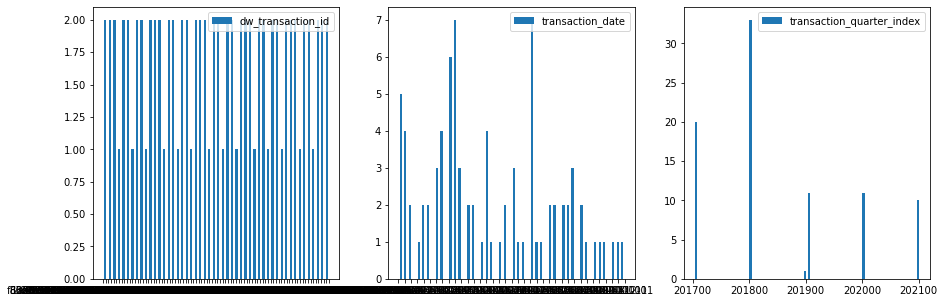

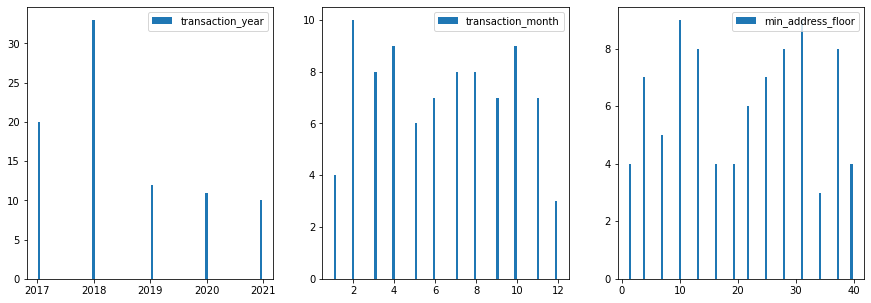

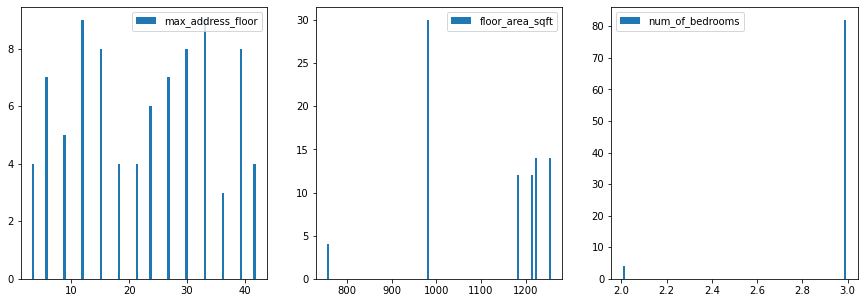

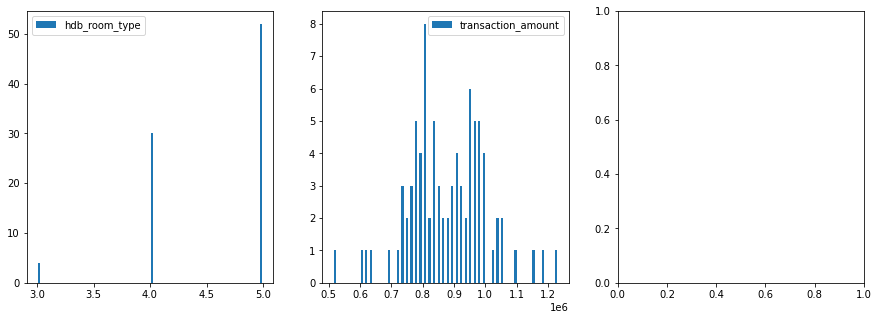

In [7]:
features = df.columns[2:]


for i in range(len(features)):
    if i % 3 == 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        ax1.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax1.legend(loc = "best")
    elif i % 3 == 1:
        ax2.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax2.legend(loc = "best")
    else:
        ax3.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax3.legend(loc = "best")
        
plt.show()

## Multicollinearity check

* We want to check for multicollinearity before we check for OLS. So we use either VIF to recursively eliminate features, or plot a correlation matrix to get some intuition. VIF is defined as $$var(\beta_j)\propto \frac{1}{1 - R^2_j}$$

* If VIF of $X_j$ is 3, then $R^2_j $ is 0.67, if 6, then 0.83.
* Iteratively remove features until no feature has a VIF higher than 6. Originally, I wanted 3, but `num_of_bedrooms` and `floor_area_sqft` have VIFs of ~5 (makes sense they are correlated), but I'll not drop them.

In [9]:


y, X = dmatrices('transaction_amount ~ transaction_year + transaction_month + min_address_floor + max_address_floor + floor_area_sqft + num_of_bedrooms + hdb_room_type', 
                 data=df, return_type='dataframe')
#pesky regex
X.columns = X.columns.str.replace("[T.&C(&)&\[&\]]","")

In [10]:
X

Intercept  transaction_year  transaction_month  min_address_floor  \
0         1.0            2017.0                8.0                4.0   
1         1.0            2018.0                7.0                7.0   
2         1.0            2019.0                4.0                1.0   
3         1.0            2020.0                3.0                7.0   
4         1.0            2017.0                6.0               31.0   
..        ...               ...                ...                ...   
81        1.0            2021.0                2.0               31.0   
82        1.0            2021.0                2.0                7.0   
83        1.0            2021.0                2.0               13.0   
84        1.0            2021.0                2.0               10.0   
85        1.0            2021.0                2.0               10.0   

    max_address_floor  floor_area_sqft  num_of_bedrooms  hdb_room_type  
0                 6.0          753.410              2.0            3.0  
1                 9.0          753.410              2.0            3.0  
2                 3.0          753.410              2.0            3.0  
3                 9.0          753.410              2.0            3.0  
4                33.0          979.433              3.0            4.0  
..                ...              ...              ...            ...  
81               33.0         1259.271              3.0            5.0  
82                9.0         1216.219              3.0            5.0  
83               15.0         1183.930              3.0            5.0  
84               12.0         1183.930              3.0            5.0  
85               12.0         1183.930              3.0            5.0  

[86 rows x 8 columns]

In [11]:
#vif function
def compute_vif(X_with_const):
    return pd.Series([variance_inflation_factor(np.array(X_with_const),i) 
                     for i in range(X_with_const.shape[1])],
                    index = X_with_const.columns)


def vif_threshold_check(vif, threshold):
    no_const = vif[1:]
    if len(no_const[no_const > threshold]) > 0:
        return True
    else:
        return False
    
# Eliminate most collinear feature until all VIF fall below a threshold
threshold = 6
vif = compute_vif(X)
print(vif)


"""
while vif_threshold_check(vif, threshold):
    max_vif = vif[1:].max()
    drop_col = vif[1:].idxmax()
    X.drop(drop_col, axis=1, inplace=True)
    print("Feature {} has been dropped with VIF = {}".format(
        drop_col, max_vif))
    vif = compute_vif(X)

print("\n{} features eliminated out of {} original features".format(
    len(X.columns) - len(X.columns) + 1, len(X.columns)))
"""

Intercept             0.000000
transaction_year      1.302690
transaction_month     1.186062
min_address_floor          inf
max_address_floor          inf
floor_area_sqft      73.804507
num_of_bedrooms       2.073216
hdb_room_type        78.269147
dtype: float64


'\nwhile vif_threshold_check(vif, threshold):\n    max_vif = vif[1:].max()\n    drop_col = vif[1:].idxmax()\n    X.drop(drop_col, axis=1, inplace=True)\n    print("Feature {} has been dropped with VIF = {}".format(\n        drop_col, max_vif))\n    vif = compute_vif(X)\n\nprint("\n{} features eliminated out of {} original features".format(\n    len(X.columns) - len(X.columns) + 1, len(X.columns)))\n'

# Determine suitability for methods

## Testing OLS assumptions 

* Fit and predict. Get a function to output an array of `residuals`.
* Test normality of residuals. Use Anderson-Darling test, another variant of the Komolgorov-Smirnov test.
* Test for autocorrelation of residuals. Use Durbin Watson.
* Test for heteroskedasticity of residuals. Use the White.

In [12]:
mod = sm.OLS(y, X)    
res = mod.fit()       
print(res.summary()) 


                            OLS Regression Results                            
Dep. Variable:     transaction_amount   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     161.1
Date:                Tue, 22 Jun 2021   Prob (F-statistic):           3.56e-42
Time:                        12:57:40   Log-Likelihood:                -1019.9
No. Observations:                  86   AIC:                             2054.
Df Residuals:                      79   BIC:                             2071.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.336e+07   2.29e+0

In [13]:
diagnostics = res.diagn
diagnostics

{'jb': 0.8325077857656753,
 'jbpv': 0.6595128036189868,
 'skew': 0.2164326688132519,
 'kurtosis': 3.212026775782348,
 'omni': 1.3153966865728857,
 'omnipv': 0.5180423189285233,
 'condno': 1.4962556097003827e+18,
 'mineigval': 2.046033348428827e-28}

0.6466073940059609


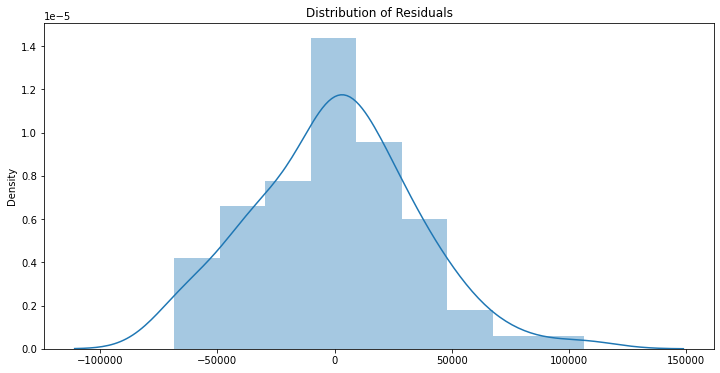

In [14]:
residuals = res.resid
ad_p_val = normal_ad(residuals)[1]
print(ad_p_val)

plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(residuals)
plt.show()

In [15]:
dw_stat = durbin_watson(residuals)
print(dw_stat)
white_pval = het_white(residuals,X)[1]
print(white_pval)

1.447260904807314
0.7328909457739444


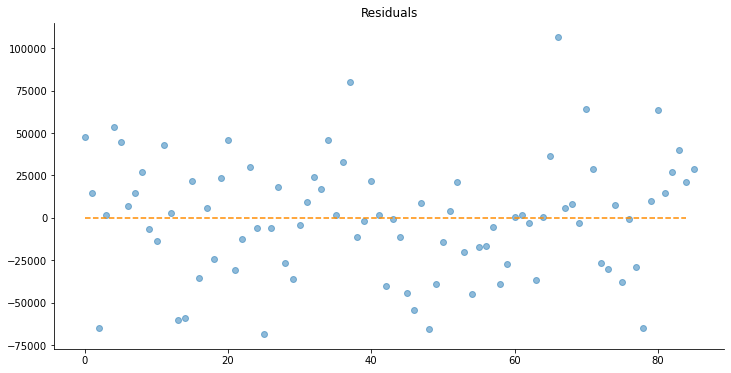

In [16]:
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=residuals.index, y=residuals, alpha=0.5)
plt.plot(np.repeat(0, residuals.index.max()), color='darkorange', linestyle='--')
ax.spines['right'].set_visible(False)  # Removing the right spine
ax.spines['top'].set_visible(False)  # Removing the top spine
plt.title('Residuals')
plt.show()  

Note how as sample size $\rightarrow 0 $ OLS assumptions are met better and OLS performs better.

# Train test split

# Model training

CV Results for rf: 

- Best combination of hyperparams:
 {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1} 

- Best mean_test_score:
 -2950297970.4202924 

-Best mean_test_score square root: 54316.64542679612 


- Score by fold for best estimator:
 [-3918889324.558028, -3973530998.231252, -2464282526.6197896, -3688983005.2785974, -705803997.4137957] 

- Top 10 hyperparams combinations by mean_test_score:
                 mean_test_score  mean_train_score param_max_depth  \
rank_test_score                                                      
1                  -2.950298e+09     -4.063870e+08              10   
2                  -2.958985e+09     -4.047182e+08              50   
3                  -2.976570e+09     -4.457659e+08               7   
4                  -3.022418e+09     -4.069572e+08              50   
5                  -3.023069e+09     -4.302073e+08               7   
6                  -3.023128e+09     -4.071231e+08              10   
7                  -3.

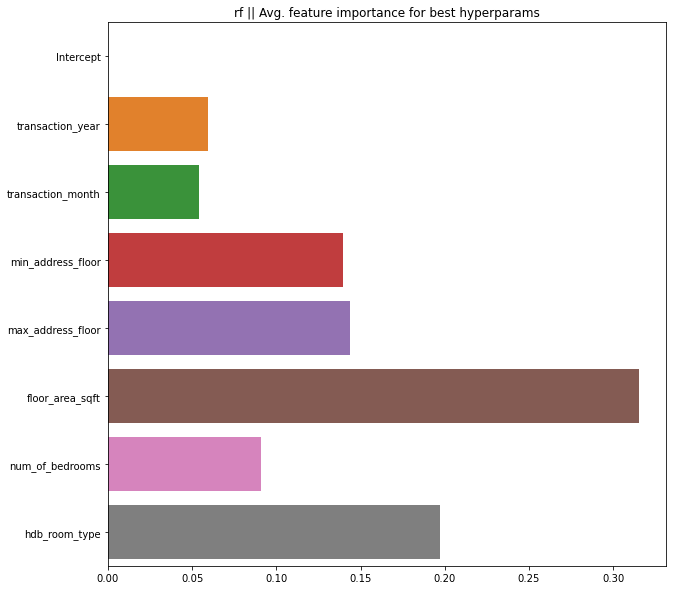

CV Results for xgb: 

- Best combination of hyperparams:
 {'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 1000} 

- Best mean_test_score:
 -2804480663.6175113 

-Best mean_test_score square root: 52957.34758857841 


- Score by fold for best estimator:
 [-3845113803.502572, -4427949496.440215, -2144442519.6460404, -2725518634.3359323, -879378864.1627984] 

- Top 10 hyperparams combinations by mean_test_score:
                 mean_test_score  mean_train_score param_n_estimators  \
rank_test_score                                                         
1                  -2.804481e+09     -3.727926e+08               1000   
2                  -2.884606e+09     -1.021114e+07               1000   
3                  -2.885111e+09     -1.021638e+07                500   
4                  -2.895716e+09     -3.397092e+08                100   
5                  -3.025344e+09     -1.021114e+07               1000   
6                  -3.025510e+09     -1.021114e+07                5

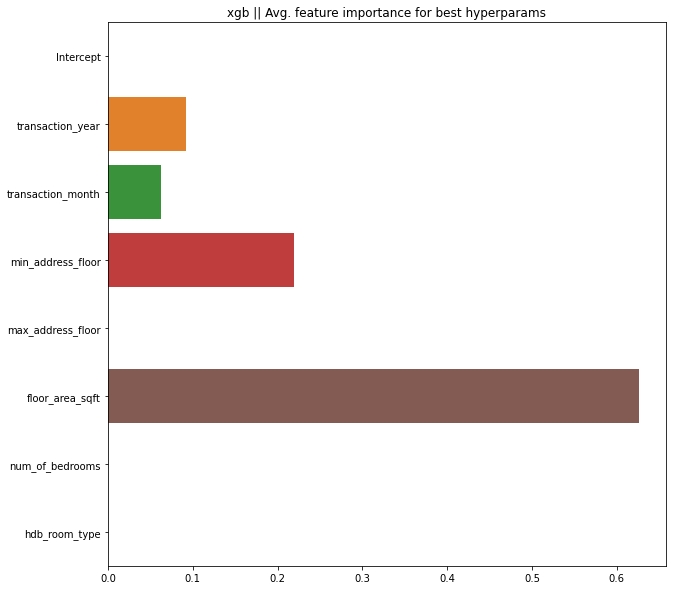

CV Results for ridge: 

- Best combination of hyperparams:
 {'alpha': 1} 

- Best mean_test_score:
 -1616051963.1187947 

-Best mean_test_score square root: 40200.148794734516 


- Score by fold for best estimator:
 [-2403367447.717886, -2231451003.4835386, -1646160374.2784646, -1163191721.0199625, -636089269.0941222] 

- Top 10 hyperparams combinations by mean_test_score:
                 mean_test_score  mean_train_score param_alpha
rank_test_score                                               
1                  -1.616052e+09     -1.240890e+09           1
2                  -1.632476e+09     -1.178133e+09         0.1
3                  -1.649325e+09     -1.171070e+09        0.01
4                  -1.727137e+09     -1.383057e+09          10
5                  -2.211704e+09     -1.787117e+09         100
6                  -2.765801e+09     -2.335282e+09        1000


In [17]:
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge

#variables
y = y
x = X

#train test split
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size =0.2)
#folds
kf5 = KFold(n_splits=5,shuffle=True,random_state=0)
#loss
mse = "neg_mean_squared_error"
mae = "neg_mean_absolute_error"
#parameter grids: 27 and 9 combinations respectively
rf_params = {"max_depth": [2,7,10,50],
              "min_samples_leaf": [1,10,20,30],
              'max_features': [2, 3, 5, "auto"]}
xgb_params = {"n_estimators": [100,500,1000],
            "max_depth":[6],
            "learning_rate":[0.25,0.05,0.005]}
ridge_params = {'alpha':[0.01, 0.1,1, 10, 100, 1000]}
#models
rf = RandomForestRegressor(random_state=0)
xgb = XGBRegressor(random_state=0)
ridge = Ridge(random_state=0)


#cross-validation object



#functions, no classes here.
def grid_object(x,y, estimator, params, scoring, cv):
    """returns a fitted object"""
    grid = GridSearchCV(estimator = estimator, param_grid = params, scoring = scoring, cv = cv,
                           n_jobs = -1, return_train_score = True)
    grid.fit(x,y)
    return grid

def report_GridSearchCV_results(grid,modelname):
    print(f"CV Results for {modelname}: \n")
    print("- Best combination of hyperparams:\n", grid.best_params_, "\n")
    print("- Best mean_test_score:\n", grid.best_score_, "\n")
    print(f"-Best mean_test_score square root: {math.sqrt(abs(grid.best_score_))} \n\n")
    
    scores = []
    for i in range(grid.n_splits_):
        scores.append(grid.cv_results_['split{}_test_score'.format(i)][grid.best_index_])
    print("- Score by fold for best estimator:\n", scores, "\n")
    
    # View top 10 hyperparams combinations by mean_test_score (averaged CV score over all folds)
    print("- Top 10 hyperparams combinations by mean_test_score:")
    print(pd.DataFrame(grid.cv_results_)[["rank_test_score", "mean_test_score","mean_train_score"] 
                                            + ["param_" + param for param in grid.param_grid]]
              .sort_values(by = "mean_test_score", ascending = False)
              .set_index("rank_test_score").head(10))
    
    return grid.best_estimator_

def plot_feature_importance(estimator,x, model_name):
    plt.figure(figsize = (10, 10))
    features, importances = x.columns, estimator.feature_importances_
    sns.barplot(importances,features, orient="h").set(title="{} || Avg. feature importance for best hyperparams".format(model_name))
    plt.show()    
    return None

#train models
rf = grid_object(x_train, np.array(y_train).ravel(),rf,rf_params,mse,kf5)
best_rf = report_GridSearchCV_results(rf,"rf")
plot_feature_importance(best_rf,x_train,"rf")

xgb = grid_object(x_train, np.array(y_train).ravel(),xgb,xgb_params,mse,kf5)
best_xgb = report_GridSearchCV_results(xgb,"xgb")
plot_feature_importance(best_xgb,x_train,"xgb")

ridge = grid_object(x_train,np.array(y_train).ravel(),ridge,ridge_params,mse,kf5)
best_ridge = report_GridSearchCV_results(ridge,"ridge")

#check which best model has better cv score and pickle it OR use the best models on test and pickle the one with better score.


# Partial Dependence Plots/SHAP variability

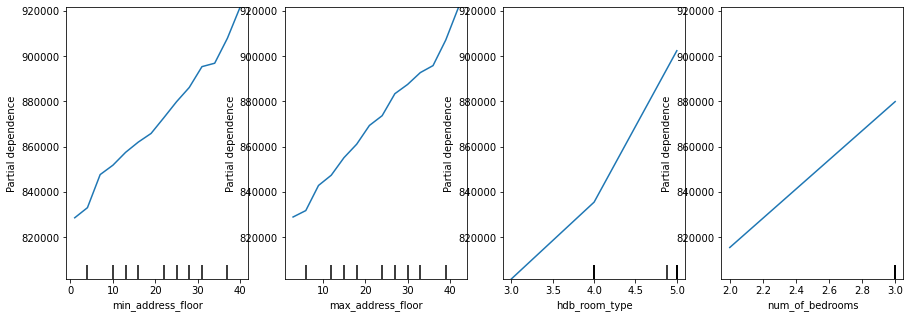

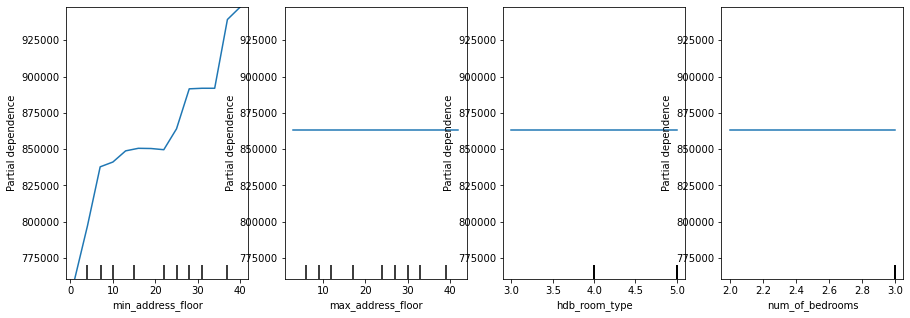

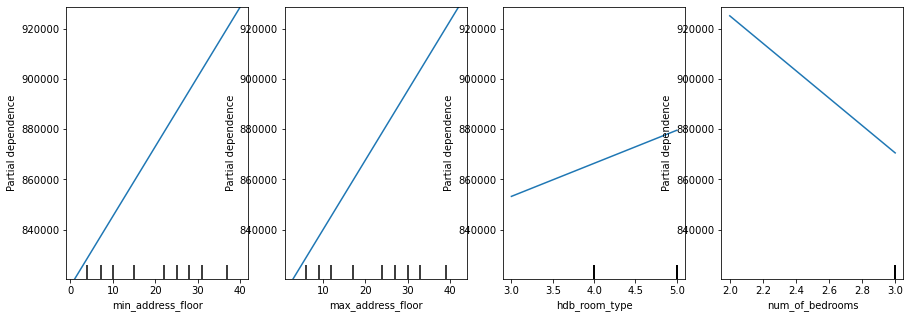

In [18]:
from sklearn.inspection import plot_partial_dependence

best_xgb.dummy_='dummy'

hdb_feature_str = ["min_address_floor","max_address_floor","hdb_room_type","num_of_bedrooms"]

fig, (ax1, ax2, ax3,ax10) = plt.subplots(1, 4, figsize=(15, 5))
fig, (ax4, ax5, ax6,ax11) = plt.subplots(1, 4, figsize=(15, 5))
fig, (ax7, ax8, ax9,ax12) = plt.subplots(1, 4, figsize=(15, 5))

plot_partial_dependence(best_rf,X,features = hdb_feature_str, ax=[ax1,ax2,ax3,ax10])
plot_partial_dependence(best_xgb,x_train,features = hdb_feature_str,ax=[ax4,ax5,ax6,ax11])
plot_partial_dependence(best_ridge,x_train,features = hdb_feature_str,ax=[ax7,ax8,ax9,ax12])

First row: RF
Second row: XGB
Third row: OLS

Note how OLS PDP for number of bedrooms is completely the opposite. Also note the XGB one is again a straight line. This is likely due to the inner workings of the XGB model. Might be something to do with multicollinearity, XGB probably somehow cuts it out because XGB is very very good.

In [20]:
from sklearn.metrics import mean_squared_error

best_rf_test_mse = mean_squared_error(y_test, best_rf.predict(x_test))
best_xgb_test_mse = mean_squared_error(y_test, best_xgb.predict(x_test))
best_ridge_test_mse = mean_squared_error(y_test,best_ridge.predict(x_test))
best_OLS_test_mse = mean_squared_error(y_test,res.predict(x_test))
print(math.sqrt(best_rf_test_mse))
print(math.sqrt(best_xgb_test_mse))
print(math.sqrt(best_ridge_test_mse))
print(math.sqrt(best_OLS_test_mse))

43792.82628880871
47504.22556961769
35186.55483066618
29927.14361587604


Note how OLS actually performs the best with small sample size. This might be due to the fact that it is easier to fit a straight line to a few points then very many points, and something to do with degrees of freedom.

In [42]:
predictions, values = partial_dependence(best_rf,x,features = ["min_address_floor"])

NameError: name 'partial_dependence' is not defined